In [ ]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as st
from mpl_toolkits import mplot3d
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KDTree
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [ ]:
# 2 mm data:

with open('data/train_data_2mm_p100.pkl', 'rb') as h:
    data = pickle.load(h)
    a, c = np.array(data[0]), np.array(data[1])


with open('data/test_data_2mm_p100.pkl', 'rb') as H:
    test = pickle.load(H)
    X_test, Y_test, Y_ = np.array(test[0]), np.array(test[1]), np.array(test[2])

In [ ]:
a.shape, X_test.shape, Y_test.shape, Y_.shape

((26187, 6), (1179, 6), (1179, 100, 3), (1179, 11, 3))

In [ ]:
df_a = pd.DataFrame(a, columns=[r'$a_1$', r'$a_2$', r'$a_3$', r'$a_4$', r'$a_5$', r'$a_6$'])

df_test_a = pd.DataFrame(X_test, columns=[r'$a_1$', r'$a_2$', r'$a_3$', r'$a_4$', r'$a_5$', r'$a_6$'])

In [ ]:
df_a.head()

$a_1$     $a_2$     $a_3$     $a_4$     $a_5$     $a_6$
0 -0.016094 -0.186605 -0.253516 -3.870918 -0.133774  3.088253
1 -0.017285 -0.209530 -0.253588 -3.908264 -0.148590  3.295073
2 -0.017294 -0.208226 -0.253211 -3.869632 -0.153419  3.285415
3 -0.021035 -0.238851 -0.269175 -3.891802 -0.122517  3.359787
4 -0.021074 -0.230291 -0.267329 -3.826611 -0.146662  3.299425

In [ ]:
stats = df_a.describe().T.reset_index()

In [ ]:
stats

index    count      mean       std       min       25%       50%       75%  \
0  $a_1$  26187.0 -0.069908  0.028944 -0.156876 -0.088121 -0.067354 -0.048737   
1  $a_2$  26187.0 -0.210539  0.405013 -1.066357 -0.476123 -0.215545  0.001848   
2  $a_3$  26187.0 -0.128175  0.325280 -0.624041 -0.335746 -0.249978 -0.089896   
3  $a_4$  26187.0 -3.405434  0.642951 -6.279725 -3.760009 -3.261565 -2.986537   
4  $a_5$  26187.0 -0.077937  1.028785 -3.692084 -0.755273 -0.294012  0.349528   
5  $a_6$  26187.0  2.782812  1.159984 -1.326203  2.515773  3.210037  3.547343   

        max  
0  0.038721  
1  0.871774  
2  0.840913  
3 -1.474182  
4  3.754607  
5  4.498693

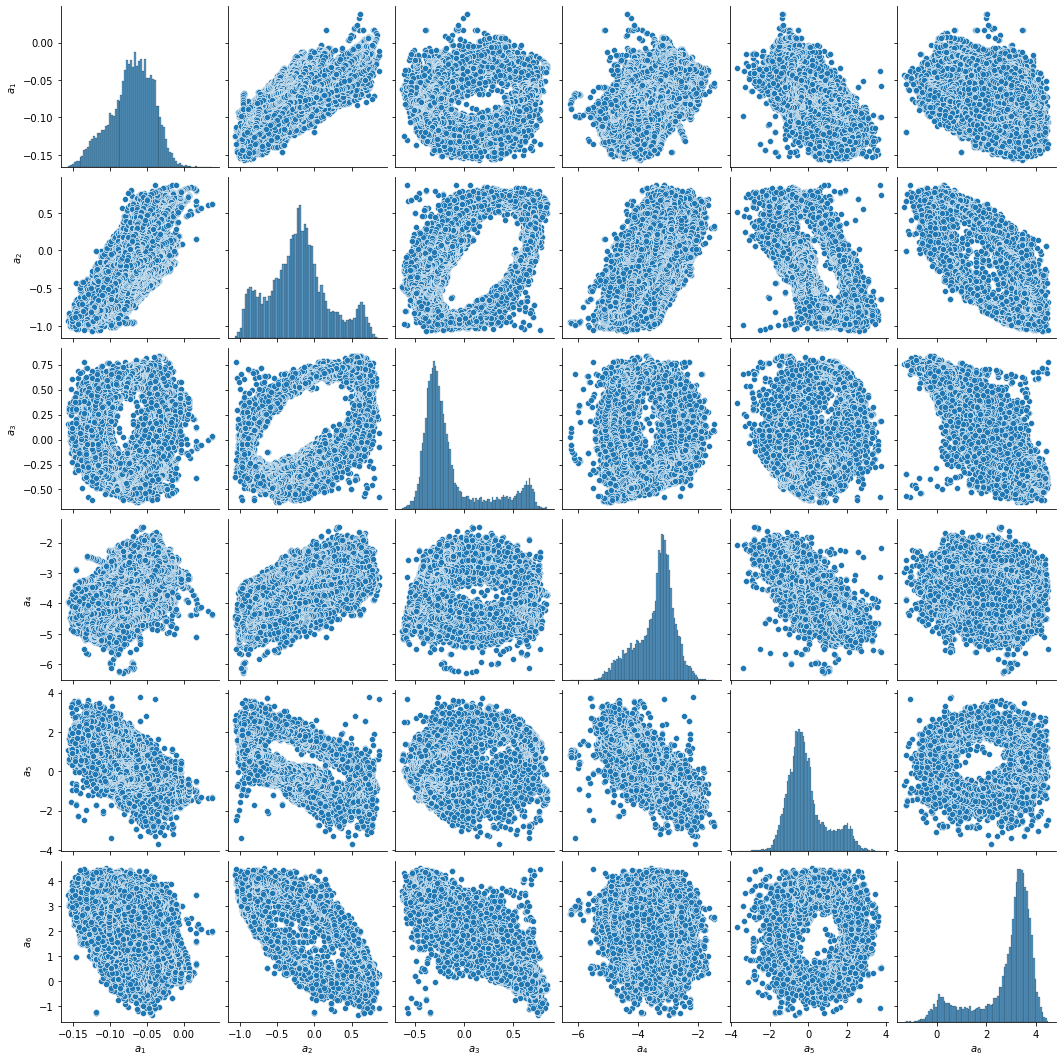

In [ ]:
sns.pairplot(df_a);

## It is interesting to note the correlation between the forces and torques.

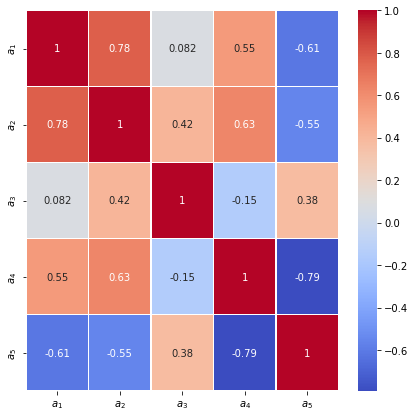

In [ ]:
corr = df_a.corr().iloc[:-1, :-1]
plt.subplots(figsize=(7,7))
sns.heatmap(corr,
           annot=True, linewidth='0.05', cmap="coolwarm");

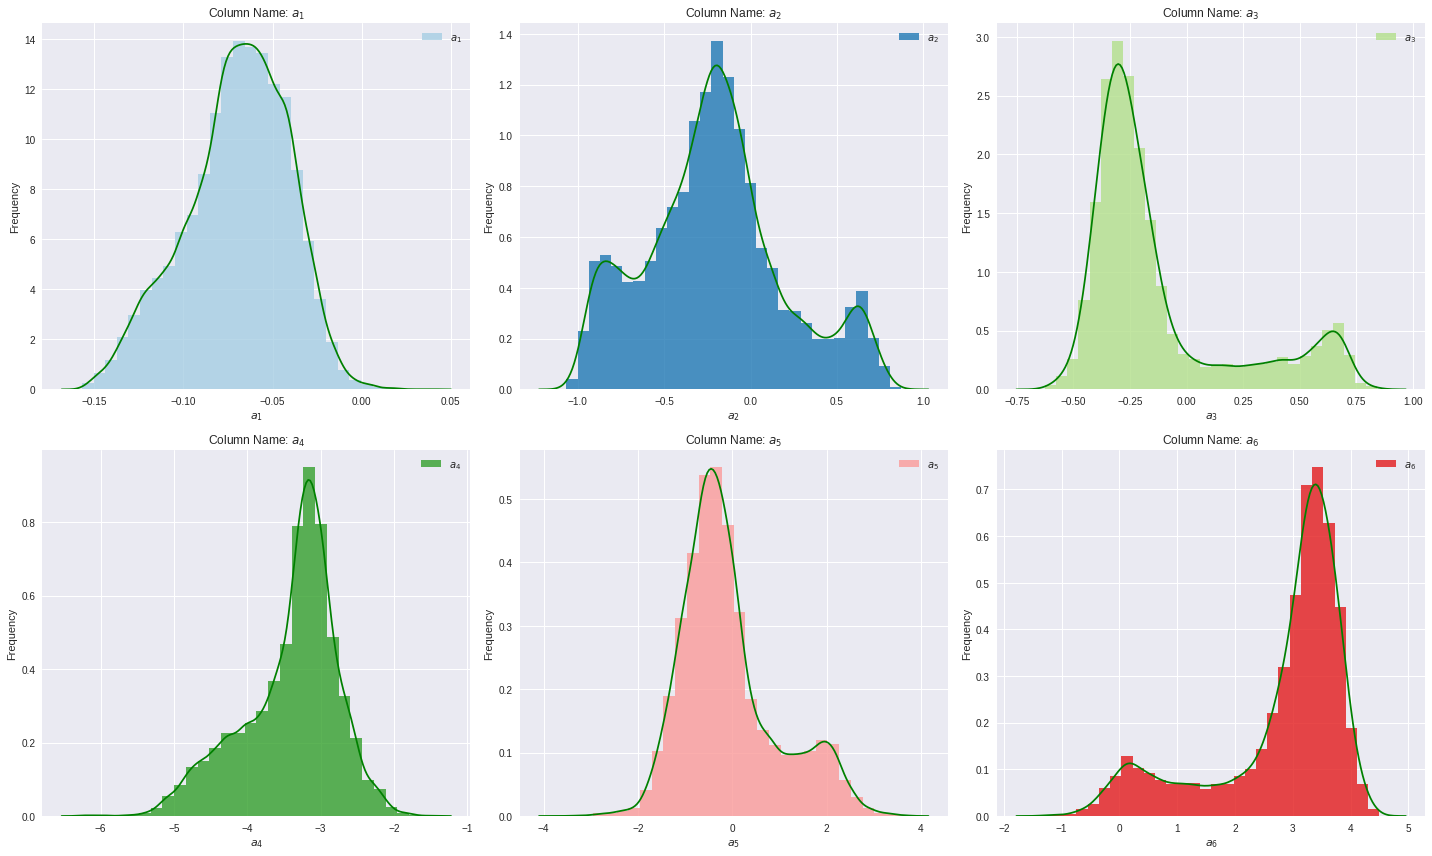

In [ ]:
plt.style.use('seaborn')
for col, ind, color in zip(df_a.columns, range(len(df_a.columns)), sns.color_palette("Paired")):
    plt.subplot(2, 3, ind+1)
    df_a[col].plot.hist(bins=30 , density=1, alpha=0.8, color=color,title='Column Name: '+ col, figsize=(20,12), legend=True)
    sns.kdeplot(df_a[col], c='g')
plt.tight_layout()

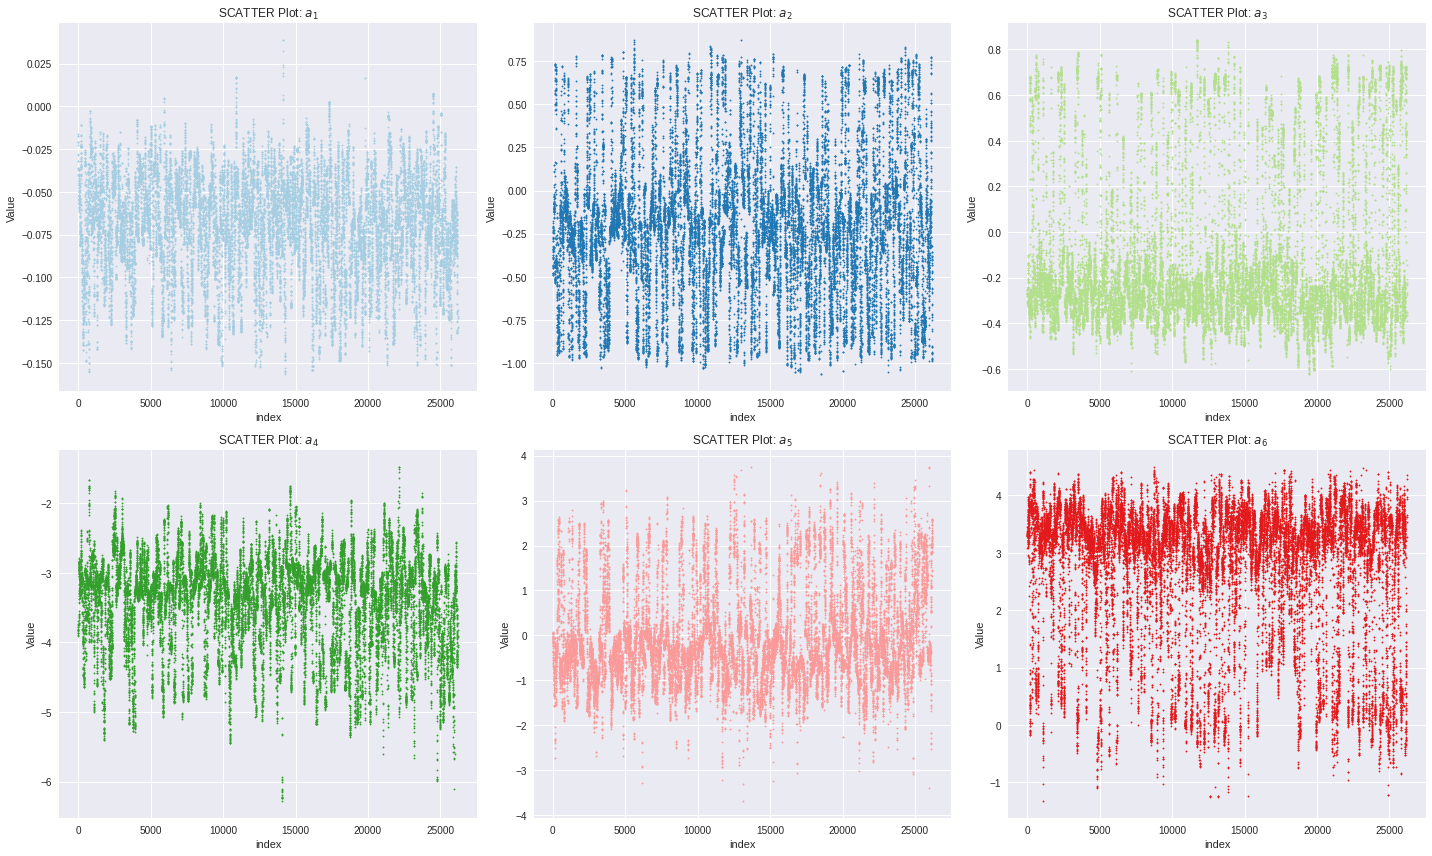

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=(20,12))
for col, ind, color in zip(df_a.columns, range(len(df_a.columns)), sns.color_palette("Paired")):
    plt.subplot(2, 3, ind+1)
    x = df_a[col].reset_index()
    plt.scatter(x['index'], x[col], marker = ".", color = color, s=8)
    plt.gca().update(dict(title='SCATTER Plot: ' +str(col) , xlabel='index', ylabel='Value'))
plt.tight_layout()

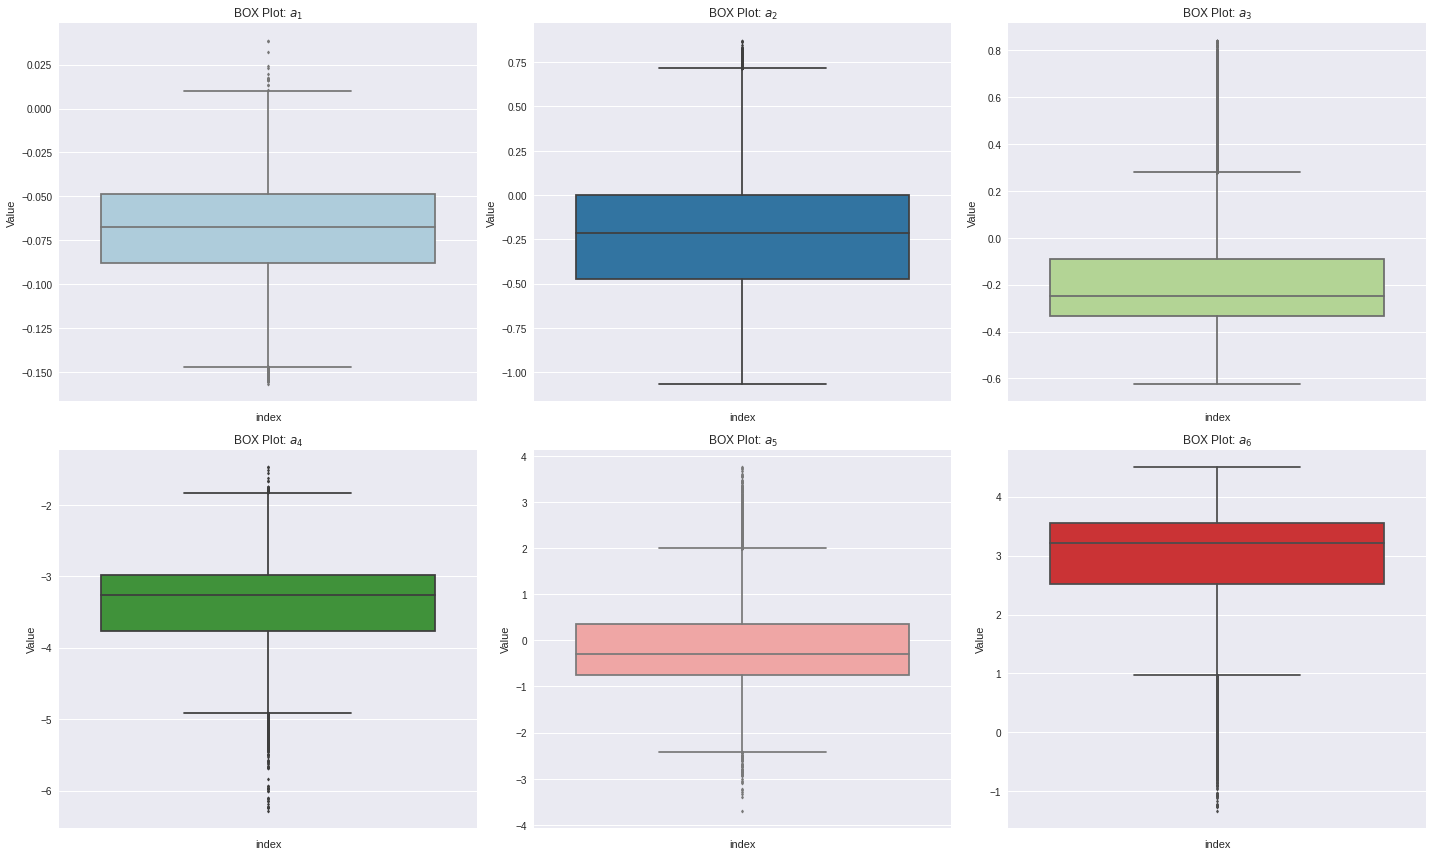

In [ ]:
plt.figure(figsize=(20,12))
for col, ind, color in zip(df_a.columns, range(len(df_a.columns)), sns.color_palette("Paired")):
    plt.subplot(2, 3, ind+1)
    sns.boxplot(y=df_a[col], color=color, fliersize=2)
    plt.gca().update(dict(title='BOX Plot: ' +str(col) , xlabel='index', ylabel='Value'))
plt.tight_layout()

### Now, after we explored and visualized the data, and we have some knowledge about the distribution of it, we can remove outliers from the data using standard deviation or interquartile range.
---

In [ ]:
# Interquartile range cleaning:

def quart(col, df):
    if type(col) == int:
        col = str(col)
    HQ = df[col].quantile(0.75)
    LQ = df[col].quantile(0.25)
    high = (HQ - LQ)*1.5 + HQ
    low = -(HQ- LQ)*1.5 + LQ
    df_filtered = df[(df[col] < high) & (df[col] > low)]
    print('Number of outliers in feature {} is {}'.format(col, df[col].shape[0] - df_filtered.shape[0]))
    return df_filtered 

# Data deviation cleaning:

def dat_dev(col, df): 
    if type(col) == int:
        col = str(col)
    x_index = df[col][(np.abs(st.zscore(df[col])) <= 3)].reset_index()
    print('Number of outliers in feature {} is {}'.format(col, df[col].shape[0] - x_index.shape[0]))
    return df.loc[x_index['index'], df.columns]

In [ ]:
# Clean train data
df_a_cleaned = df_a.copy()
c_cleaned = c.copy()
for col_ in df_a_cleaned.columns:
    df_a_cleaned = dat_dev(col_, df_a_cleaned)
    c_cleaned = c_cleaned[df_a_cleaned.index]
    df_a_cleaned.reset_index(inplace=True, drop=True)

Number of outliers in feature $a_1$ is 9
Number of outliers in feature $a_2$ is 0
Number of outliers in feature $a_3$ is 0
Number of outliers in feature $a_4$ is 68
Number of outliers in feature $a_5$ is 69
Number of outliers in feature $a_6$ is 58


In [ ]:
df_a_cleaned.shape, df_a.shape, c_cleaned.shape, c.shape

((25983, 6), (26187, 6), (25983, 100, 3), (26187, 100, 3))

In [ ]:
# Clean test data
df_a_test_cleaned = df_test_a.copy()
Y_test_cleaned = Y_test.copy()
for col_ in df_a_test_cleaned.columns:
    df_a_test_cleaned = dat_dev(col_, df_a_test_cleaned)
    Y_test_cleaned = Y_test_cleaned[df_a_test_cleaned.index]
    df_a_test_cleaned.reset_index(inplace=True, drop=True)

Number of outliers in feature $a_1$ is 0
Number of outliers in feature $a_2$ is 0
Number of outliers in feature $a_3$ is 0
Number of outliers in feature $a_4$ is 0
Number of outliers in feature $a_5$ is 2
Number of outliers in feature $a_6$ is 3


In [ ]:
df_a_test_cleaned.shape, df_test_a.shape, Y_test_cleaned.shape, Y_test.shape

((1174, 6), (1179, 6), (1174, 100, 3), (1179, 100, 3))

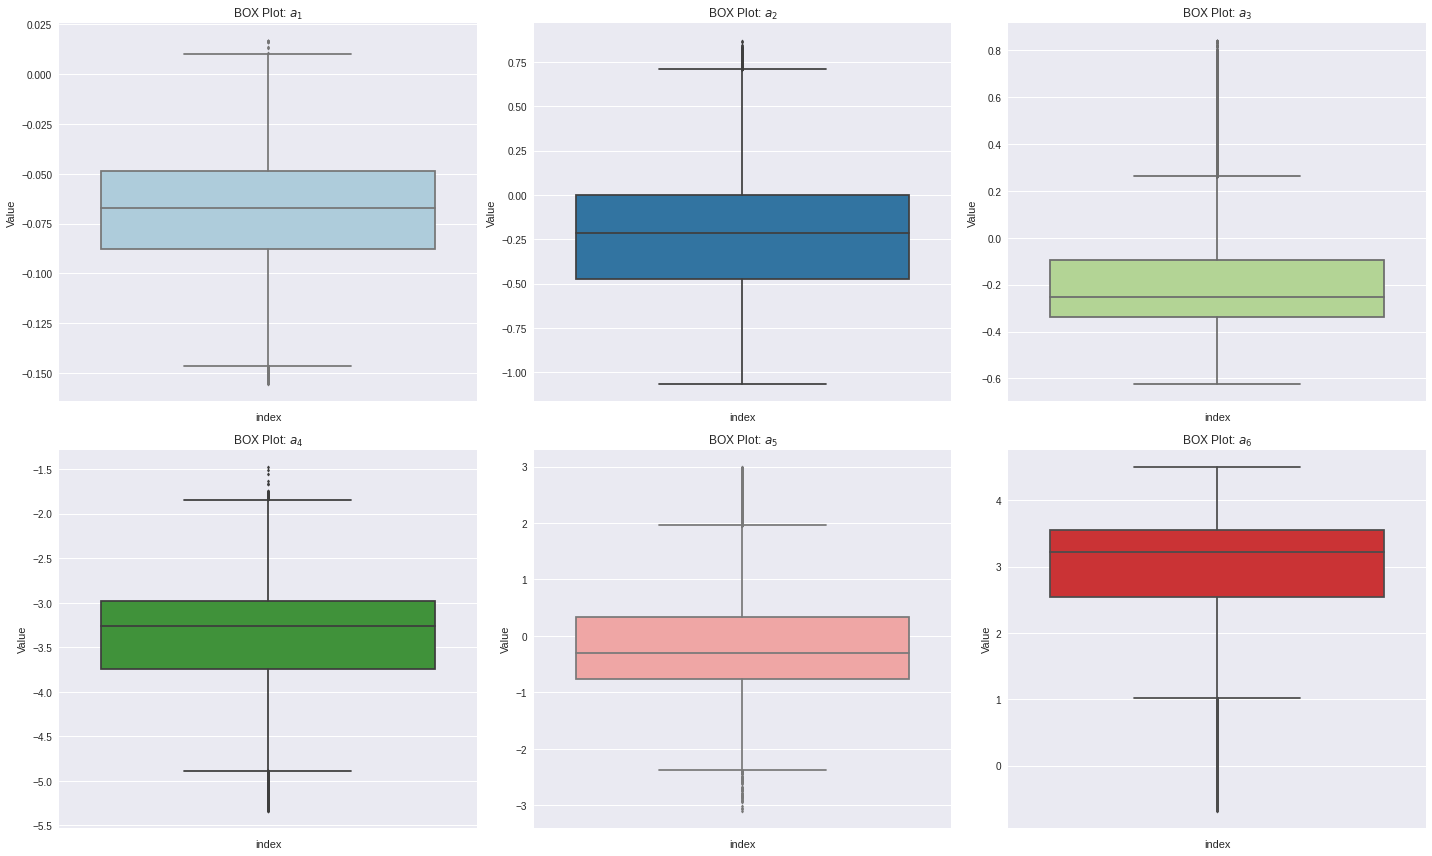

In [ ]:
plt.figure(figsize=(20,12))
for col, ind, color in zip(df_a_cleaned.columns, range(len(df_a_cleaned.columns)), sns.color_palette("Paired")):
    plt.subplot(2, 3, ind+1)
    sns.boxplot(y=df_a_cleaned[col], color=color, fliersize=2)
    plt.gca().update(dict(title='BOX Plot: ' +str(col) , xlabel='index', ylabel='Value'))
plt.tight_layout()

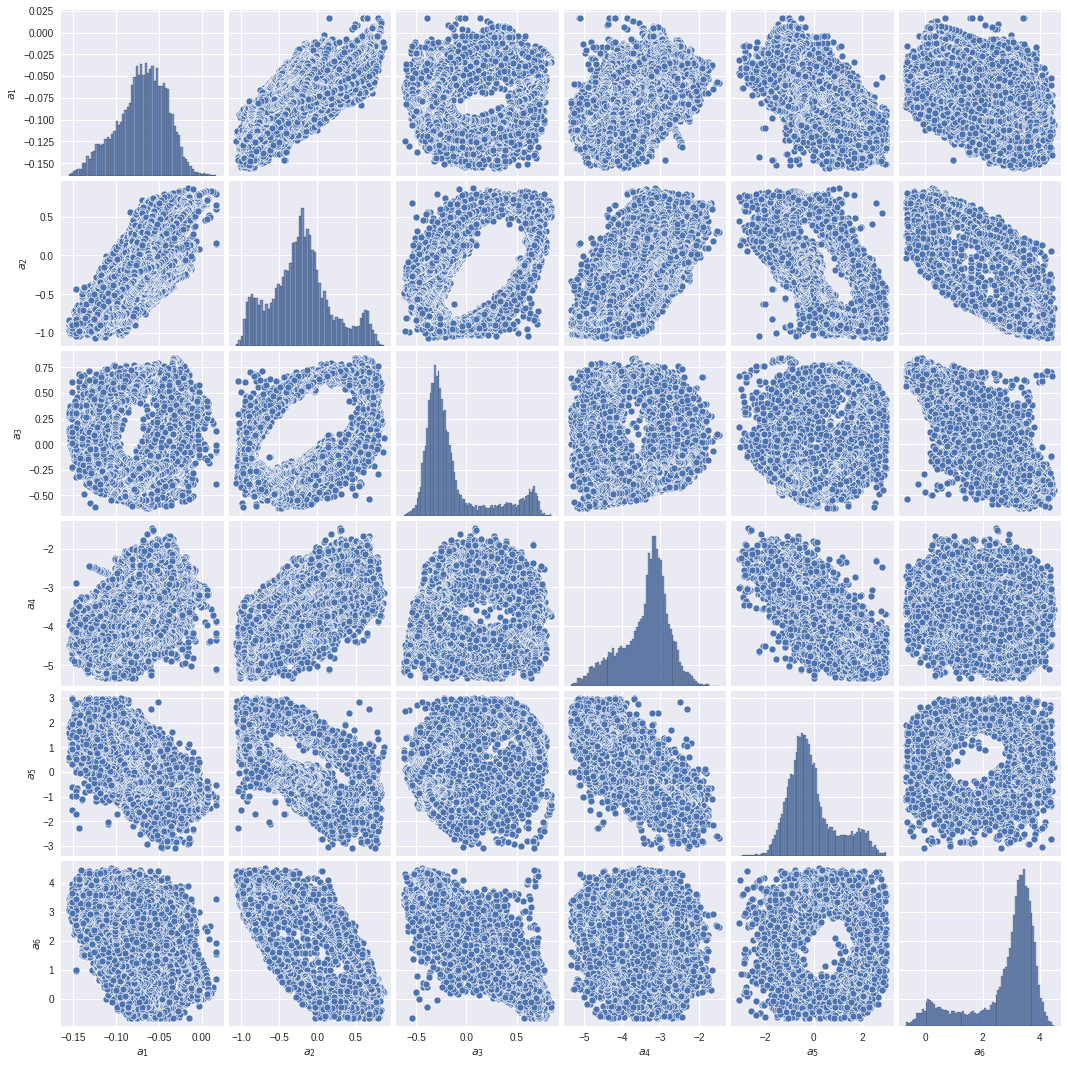

In [ ]:
sns.pairplot(df_a_cleaned);

## Checking for bad samples in the cable shape dataset:
---
#### We look for samples where the distance between two sequential points along the wire is abnormal.

In [ ]:
full_dis = []
for row in c_cleaned:
    # row is with dim of (100, 3)
    distances = []
    for ind, point in enumerate(row):
        if ind == 0:
            distances.append(np.linalg.norm(point - np.zeros(3)))
        else:
            distances.append(np.linalg.norm(point - row[ind - 1]))
    full_dis.append(distances)

full_dis = np.array(full_dis)

In [ ]:
full_dis_df = pd.DataFrame(full_dis, columns=[str(i) for i in range(100)])

In [ ]:
df_a_cleaned2 = df_a_cleaned.copy()
df_c_cleaned2 = full_dis_df.copy()
c_cleaned2 = c_cleaned.copy()
for col_ in df_c_cleaned2.columns:
    df_c_cleaned2 = dat_dev(col_, df_c_cleaned2)
    df_a_cleaned2 = df_a_cleaned2.iloc[df_c_cleaned2.index]
    c_cleaned2 = c_cleaned2[df_c_cleaned2.index]
    df_c_cleaned2.reset_index(inplace=True, drop=True)
    df_a_cleaned2.reset_index(inplace=True, drop=True)

Number of outliers in feature 0 is 360
Number of outliers in feature 1 is 223
Number of outliers in feature 2 is 96
Number of outliers in feature 3 is 100
Number of outliers in feature 4 is 69
Number of outliers in feature 5 is 39
Number of outliers in feature 6 is 13
Number of outliers in feature 7 is 40
Number of outliers in feature 8 is 10
Number of outliers in feature 9 is 11
Number of outliers in feature 10 is 8
Number of outliers in feature 11 is 26
Number of outliers in feature 12 is 30
Number of outliers in feature 13 is 53
Number of outliers in feature 14 is 34
Number of outliers in feature 15 is 28
Number of outliers in feature 16 is 22
Number of outliers in feature 17 is 10
Number of outliers in feature 18 is 9
Number of outliers in feature 19 is 4
Number of outliers in feature 20 is 0
Number of outliers in feature 21 is 0
Number of outliers in feature 22 is 0
Number of outliers in feature 23 is 2
Number of outliers in feature 24 is 7
Number of outliers in feature 25 is 15
N

In [ ]:
print(f'Total outliers removel: {df_a_cleaned.shape[0] - df_a_cleaned2.shape[0]}')

Total outliers removel: 1819


In [ ]:
c_cleaned2.shape

(24164, 100, 3)

In [ ]:
%matplotlib notebook
from ipywidgets import *

fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')

def update(sample = np.random.randint(c_cleaned2.shape[0]-1)):
    ax.clear()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(-0.1, 0.4)
    ax.set_ylim(-0.2, 0.3)
    ax.set_zlim(-0.4, 0.2)
    ax.plot3D(c_cleaned2[sample, :,0], c_cleaned2[sample, :,1], c_cleaned2[sample, :,2], '-k')
    plt.show()

interactive_plot = interactive(update, sample=(0, c_cleaned2.shape[0]-1, 1))
interactive_plot

<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=19671, description='sample', max=24163), Output()), _dom_classes=('widge…

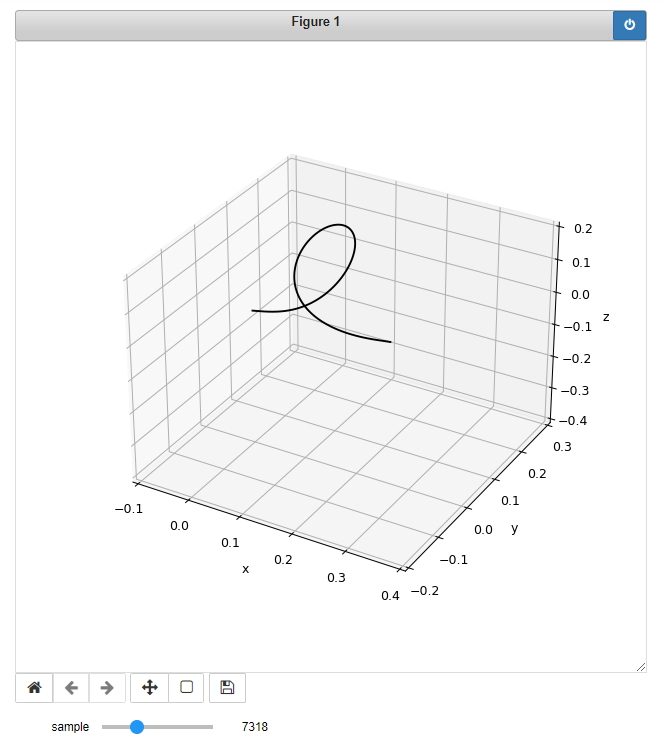

# Now that the data has been processed, we can start working!
---

In [ ]:
with open('data/train_data.pkl', 'wb') as h:
    pickle.dump((df_a_cleaned2.to_numpy(), c_cleaned2), h)

with open('data/test_data.pkl', 'wb') as h:
    pickle.dump((df_a_test_cleaned.to_numpy(), Y_test_cleaned), h)